## 데이터 불러오기 및 패키지 설치

In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '../../data/' # 환경에 맞게 바꿔주시면 됩니다.

train_df = pd.read_csv(path + 'train_data.csv')
test_df = pd.read_csv(path + 'test_data.csv')

SEED = 42

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


# 1. 데이터 전처리

In [3]:
# assessmentItemID 분할
"""
train_df['test_group'] = train_df['assessmentItemID'].str[2]
train_df['problem_id'] = train_df['assessmentItemID'].str[-3:]

test_df['test_group'] = test_df['assessmentItemID'].str[2]
test_df['problem_id'] = test_df['assessmentItemID'].str[-3:]
"""

"\ntrain_df['test_group'] = train_df['assessmentItemID'].str[2]\ntrain_df['problem_id'] = train_df['assessmentItemID'].str[-3:]\n\ntest_df['test_group'] = test_df['assessmentItemID'].str[2]\ntest_df['problem_id'] = test_df['assessmentItemID'].str[-3:]\n"

In [4]:
# Timestamp 변환 및 분할
"""
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
train_df['hour'] = train_df['Timestamp'].dt.hour

test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])
test_df['hour'] = test_df['Timestamp'].dt.hour
"""

"\ntrain_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])\ntrain_df['hour'] = train_df['Timestamp'].dt.hour\n\ntest_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])\ntest_df['hour'] = test_df['Timestamp'].dt.hour\n"

AnswerCode 활용 변수 생성 => 이렇게 명시적으로 전해주는 것이 성능에 도움이 될까?

In [5]:
# user를 기준으로 한 정답 정보는 시간순서를 고려하여 계산
train_df['user_correct_answer'] = train_df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
train_df['user_total_answer'] = train_df.groupby('userID')['answerCode'].cumcount()
train_df['user_correct_rate'] = train_df['user_correct_answer'] / train_df['user_total_answer']

test_df['user_correct_answer'] = test_df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
test_df['user_total_answer'] = test_df.groupby('userID')['answerCode'].cumcount()
test_df['user_correct_rate'] = test_df['user_correct_answer'] / test_df['user_total_answer']

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   userID               int64  
 1   assessmentItemID     object 
 2   testId               object 
 3   answerCode           int64  
 4   Timestamp            object 
 5   KnowledgeTag         int64  
 6   user_correct_answer  float64
 7   user_total_answer    int64  
 8   user_correct_rate    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 155.6+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260114 entries, 0 to 260113
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   userID               260114 non-null  int64  
 1   assessmentItemID     260114 non-null  object 
 2   testId               260114 non-null  object 
 3   answerCode           260114 non-null  int64  
 4   Timestamp            260114 non-null  object 
 5   KnowledgeTag         260114 non-null  int64  
 6   user_correct_answer  259370 non-null  float64
 7   user_total_answer    260114 non-null  int64  
 8   user_correct_rate    259370 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 17.9+ MB


# 2. train/valid 데이터 분할

In [8]:
ratio = 0.8 # test/valid 비율 설정

userids = train_df['userID'].unique()

random.seed(SEED)
random.shuffle(userids)

size = int(len(userids) * ratio)
train_userids = userids[:size]
valid_userids = userids[size:]

train = train_df.loc[train_df['userID'].isin(train_userids)]
valid = train_df.loc[train_df['userID'].isin(valid_userids)]

# 3. CatBoost

In [9]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
cat_features = [f for f in train_df.columns if train_df[f].dtype == 'object']

train_pool = Pool(data=train.drop(['answerCode'], axis=1), label=train['answerCode'], cat_features=cat_features)
valid_pool = Pool(data=valid.drop(['answerCode'], axis=1), label=valid['answerCode'], cat_features=cat_features)

In [11]:
# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# random sampler
sampler = TPESampler(seed=SEED)

# define function
def objective(trial):

    cbc_param = {
        'iterations':trial.suggest_int("iterations", 1000, 10000),
        'od_wait':trial.suggest_int('od_wait', 50, 250),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'loss_function':trial.suggest_categorical('loss_function', ['Logloss','CrossEntropy'])
    }

    # Generate model
    cbc = CatBoostClassifier(**cbc_param, 
                            eval_metric='AUC',
                            custom_metric=['AUC', 'Accuracy'],
                            cat_features=cat_features,
                            verbose=100,
                            random_seed=SEED)
    cbc.fit(train_pool, 
            eval_set=valid_pool)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    AUC = roc_auc_score(valid['answerCode'], np.array(cbc.predict_proba(valid_pool)).T[1])
    return AUC

optuna_cbc = optuna.create_study(direction='maximize', sampler=sampler)
optuna_cbc.optimize(objective, n_trials=2)  # 빨리 돌려서 테스트하려고 2로 설정

[I 2022-11-18 08:12:42,797] A new study created in memory with name: no-name-0b96a35f-6117-4852-a4a8-9df028dcaf71


0:	test: 0.6760083	best: 0.6760083 (0)	total: 502ms	remaining: 36m 34s
100:	test: 0.7831078	best: 0.7831078 (100)	total: 17.6s	remaining: 12m 23s
200:	test: 0.7839566	best: 0.7840390 (189)	total: 34.3s	remaining: 11m 51s
300:	test: 0.7842465	best: 0.7842845 (290)	total: 50.9s	remaining: 11m 28s
400:	test: 0.7843324	best: 0.7843715 (396)	total: 1m 10s	remaining: 11m 41s
500:	test: 0.7844338	best: 0.7844574 (478)	total: 1m 31s	remaining: 11m 43s
600:	test: 0.7844972	best: 0.7844972 (600)	total: 1m 50s	remaining: 11m 36s
700:	test: 0.7845016	best: 0.7845245 (676)	total: 2m 8s	remaining: 11m 13s
800:	test: 0.7845608	best: 0.7845938 (779)	total: 2m 25s	remaining: 10m 46s
900:	test: 0.7846146	best: 0.7846337 (892)	total: 2m 41s	remaining: 10m 22s
1000:	test: 0.7846340	best: 0.7846349 (986)	total: 2m 57s	remaining: 9m 58s
1100:	test: 0.7846481	best: 0.7846918 (1061)	total: 3m 14s	remaining: 9m 38s
1200:	test: 0.7846704	best: 0.7846918 (1061)	total: 3m 31s	remaining: 9m 18s
1300:	test: 0.78465

[I 2022-11-18 08:16:37,677] Trial 0 finished with value: 0.784691770459307 and parameters: {'iterations': 4371, 'od_wait': 241, 'learning_rate': 0.7346740023932911, 'reg_lambda': 59.86585243311882, 'subsample': 0.15601864044243652, 'random_strength': 16.239780813448107, 'depth': 1, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 10, 'bagging_temperature': 6.79657809075816, 'colsample_bylevel': 0.41235069657748147, 'loss_function': 'Logloss'}. Best is trial 0 with value: 0.784691770459307.


0:	test: 0.7504424	best: 0.7504424 (0)	total: 788ms	remaining: 38m 12s
100:	test: 0.7867310	best: 0.7867310 (100)	total: 1m 17s	remaining: 35m 46s
200:	test: 0.7879939	best: 0.7880959 (193)	total: 3m 1s	remaining: 40m 44s
300:	test: 0.7881823	best: 0.7883233 (251)	total: 4m 31s	remaining: 39m 10s
Stopped by overfitting detector  (86 iterations wait)

bestTest = 0.7883232653
bestIteration = 251

Shrink model to first 252 iterations.


[I 2022-11-18 08:21:53,948] Trial 1 finished with value: 0.7883232653393244 and parameters: {'iterations': 2911, 'od_wait': 86, 'learning_rate': 0.1915704647548995, 'reg_lambda': 30.424231253531342, 'subsample': 0.5247564316322378, 'random_strength': 27.27780074568463, 'depth': 5, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.14742753159914673, 'colsample_bylevel': 0.619817105976215, 'loss_function': 'CrossEntropy'}. Best is trial 1 with value: 0.7883232653393244.


In [12]:

cbc_trial = optuna_cbc.best_trial
cbc_trial_params = cbc_trial.params
print('Best Trial: score {},\nparams {}'.format(cbc_trial.value, cbc_trial_params))

Best Trial: score 0.7883232653393244,
params {'iterations': 2911, 'od_wait': 86, 'learning_rate': 0.1915704647548995, 'reg_lambda': 30.424231253531342, 'subsample': 0.5247564316322378, 'random_strength': 27.27780074568463, 'depth': 5, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.14742753159914673, 'colsample_bylevel': 0.619817105976215, 'loss_function': 'CrossEntropy'}


In [13]:
model = CatBoostClassifier(**cbc_trial_params, 
                            eval_metric='AUC',
                            custom_metric=['AUC', 'Accuracy'],
                            cat_features=cat_features,
                            verbose=100,
                            random_seed=SEED)

In [14]:
model.fit(
    train_pool, 
    eval_set=valid_pool,
    use_best_model=True,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7504424	best: 0.7504424 (0)	total: 749ms	remaining: 36m 20s
100:	test: 0.7867310	best: 0.7867310 (100)	total: 1m 6s	remaining: 30m 50s
200:	test: 0.7879939	best: 0.7880959 (193)	total: 2m 33s	remaining: 34m 33s
300:	test: 0.7881823	best: 0.7883233 (251)	total: 4m	remaining: 34m 46s
Stopped by overfitting detector  (86 iterations wait)

bestTest = 0.7883232653
bestIteration = 251

Shrink model to first 252 iterations.


In [15]:
roc_auc_score(valid['answerCode'], model.predict(valid_pool))

0.6888071317197569

In [16]:
roc_auc_score(valid['answerCode'], np.array(model.predict_proba(valid_pool)).T[1])

0.7883232653393244

출력값을 1/0 이진이 아닌 확률값으로 받아야 학습할 때의 성능이 나온다

## 학습 결과 분석

Text(0.5, 1.0, 'Feature Importance')

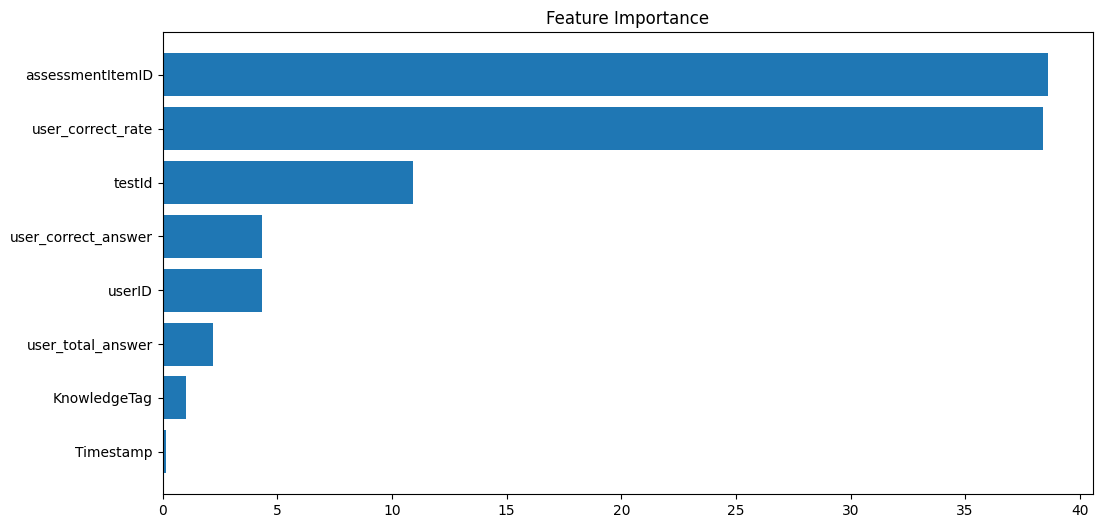

In [17]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.drop(['answerCode'], axis=1).columns)[sorted_idx])
plt.title('Feature Importance')


# 4. Test

In [18]:
model.best_score_['validation']['AUC']

0.7883232653393244

In [19]:
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

In [20]:
test_pool = Pool(data=test_df.drop(['answerCode'], axis=1), label=test_df['answerCode'], cat_features=cat_features)

In [21]:
pred = np.array(model.predict_proba(test_pool)).T[1]

In [22]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, f"{model.best_score_['validation']['AUC']:.4f}_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(pred):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/0.7883_submission.csv
